# Integrating GPU libraries for fun and profit

### ...on extending and interfacing HPC simulation tools

##### Authors: Adrian Oeftiger and Martin Schwinzerl

# Abstract

I have a high-performance number crunching tool with cool physics which simulates long-term on a GPU &ndash; how can I extend the inner loop by further cool physics, injected from the outside?
In python this should be easy, right? But wait... we are sitting on device memory?

In this talk we explore how to tightly couple two libraries for high-performance computation of long-term beam dynamics, `SixTrackLib` and `PyHEADTAIL`. How can we design the _interface_ between both libraries in terms of

(1) remaining on the python level,

(2) avoid losing performance due to device-to-host-to-device copies, and

(3) keeping both libraries as stand-alone packages?

The interface can be surprisingly simple, yet fully fledged... Let's go!

# ... the physics ...

# Collective beam dynamics

3D particle motion $\leadsto$ 6 phase space coordinates:
$$\mathbb{X}=(\underbrace{x, x'\vphantom{y'}}_{horizontal}, \underbrace{y, y'}_{vertical}, \underbrace{z, \delta\vphantom{y'}}_{longitudinal})$$

A beam $=$ state of $N$ macro-particles $=$ $6N$ values of phase space coordinates

## Simulations:
* typically up to $\mathcal{O}(10^6)$ macro-particles
* accelerator elements to track through: up to $\mathcal{O}(1000)$
* simulations can last up to $\mathcal{O}(10^6)$ turns 
* particle-to-particle interaction: binning, FFT, convolution, particle-in-cell, Poisson solvers

# Requirements for simulation tools

* long-term evolution $\leadsto$ **double precision**
* heavy **number crunching** $\leadsto$ high-performance computing (**HPC**)<br />(in particular for _collective effects_ i.e. particle-to-particle interaction)
* **iterative development**, frequent update of accelerator models $\leadsto$ python

# Single-particle vs. multi-particle dynamics

**single-particle** $\implies$ <span style="color:#00aad4;">"tracking"</span>: particle motion due to external focusing (magnets and RF cavities)

**multi-particle** $\implies$ <span style="color:#aa0000;">"collective effect kicks"</span>: direct and indirect particle-to-particle interaction

<center>
<img src="images/transverse-model_empty.png" alt="sketch of one-turn map for ring" style="width:30%;"/>
Tracking around the accelerator ring
</center>

# The `PyHEADTAIL` library

Python based code for simulating collective beam dynamics: [github repo $\nearrow$](https://github.com/PyCOMPLETE/PyHEADTAIL)

$\implies$ simplified matrix-based <span style="color:#00aad4;">tracking</span>

$\implies$ **strong:** detailed models for <span style="color:#aa0000;">collective effect kicks</span>

<center>
<img src="images/wakefield.png" alt="wake field sketch" style="width:30%;"/>
Example for a kick: wakefield induced by leading particles imparting kicks on trailing particles
</center>

# The `SixTrackLib` library

C templated code with Python API for simulating single-particle beam dynamics: [github repo $\nearrow$](https://github.com/sixtrack/sixtracklib)

$\implies$ **strong:** advanced non-linear <span style="color:#00aad4;">tracking</span>

$\implies$ approximative / simplified models for <span style="color:#aa0000;">collective effect kicks</span>

<center>
<img src="images/tracking.png" alt="tracking sketch" style="width:30%;"/>
Example for tracking: <span style="color:#ff6701;">dipole magnets bend</span> and <span style="color:#800000;">quadrupole magnets (de-)</span><span style="color:#000080;">focus</span> particles
</center>

# ... the HPC part ...

# `PyHEADTAIL` on the GPU

[Concept presented on PyHEP'19 $\nearrow$](https://indico.cern.ch/event/833895/contributions/3577801/), in short:

<div style="float: right; width: 10%">
<img src="images/duck.png" alt="duck typing" style="width: 100%;" /> <br />
<!-- <img src="pycuda-logo2.png" alt="PyCUDA logo" style="width: 100%;" /> -->
</div>

* utilise **duck typing** to separate physics from back-end implementation
* sandwich layer via **context management** and **function redirection**<br />(separate math dictionaries for CPU and GPU)
* exploit GPU via `PyCUDA` (`CuPy` would work similarly)

In [ ]:
# tracking loop in PyHEADTAIL:
with GPU(pyht_beam):
    for i in range(n_turns):
        for element in pyht_ring_elements:
            element.track(pyht_beam)

$\implies$ implement physics only once! <br />
$\implies$ back-end details transparent to users / high-level developers

# `SixTrackLib` on the GPU

[Concept presented on PyHEP'19 $\nearrow$](https://indico.cern.ch/event/833895/contributions/3577803/), in short:

* Python API for dynamic interaction
* C **templating approach** to separate physics from back-end implementation
    * implementation in usual C for (single-core) CPU
    * implementation in openCL for multi-core CPU and GPU (AMD, NVIDIA)
    * implementation in CUDA for NVIDIA GPUs

In [ ]:
# tracking kernel in SixTrackLib
trackjob = stl.TrackJob(stl_ring_elements, stl_beam, device='opencl:0.0')
trackjob.track_until(n_turns)

$\implies$ implement physics only once! <br />
$\implies$ users launch "trackjobs" with just a single `device` keyword to switch architecture

# ... the quest ...

# `SixTrackLib` $+$ `PyHEADTAIL` $=$ <3 ?

`SixTrackLib` $\rightarrow$ strong in advanced non-linear <span style="color:#00aad4;">tracking</span>

`PyHEADTAIL` $\rightarrow$ strong in <span style="color:#aa0000;">collective effect kicks</span>

$\implies$ `SixTrackLib` $+$ `PyHEADTAIL` $=$ strong in both?

<center>
<img src="images/transverse-model_integration.png" alt="integrating PyHEADTAIL and SixTrackLib" style="width:30%;"/>
Alternating SixTrackLib <span style="color:#00aad4;">tracking</span> and PyHEADTAIL <span style="color:#aa0000;">kicking</span>
</center>

# ... the quest*ions* ...

Situation:
* `PyHEADTAIL` on the GPU lives in `PyCUDA`, managed from user script
* `SixTrackLib` on the GPU manages its CUDA kernel invocation by itself
* beam state data: <br />`PyHEADTAIL` uses `PyCUDA.GPUArrays` while `SixTrackLib` uses custom memory buffers

Critical aspects:
* how to hand over the data between the two codes?
* how to avoid GPU - CPU - GPU memory transfer?
* can `PyHEADTAIL`'s `PyCUDA` context interact with `SixTrackLib`'s initialised context? 
    * visibility of memory to each other
    * alternating kernel calls?
    * flow control from python level?

# ... example simulation with `PyHEADTAIL` ...

## ... a head-tail instability in the future FAIR SIS100 synchrotron ...

In [1]:
# set up plotting, pythonpath etc
from imports import *

Importing PyHEADTAIL:

In [2]:
# initialise CUDA context for PyHEADTAIL via pycuda
from pycuda.autoinit import context

import PyHEADTAIL

PyHEADTAIL v1.14.1.10




# Setting up <span style="color:#00aad4;">tracking</span> around the SIS100 ring

Transverse tracking:

In [3]:
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.detuners import Chromaticity

from pyheadtail_setup import transverse_map_kwargs, Q_x, Q_y

In [4]:
transverse_map = TransverseMap(
    detuners=[Chromaticity(Q_x, Q_y)],
    **transverse_map_kwargs,
)

Longitudinal tracking:

In [5]:
from PyHEADTAIL.trackers.longitudinal_tracking import RFSystems

from pyheadtail_setup import longitudinal_map_kwargs

In [6]:
longitudinal_map = RFSystems(**longitudinal_map_kwargs)

# Setting up <span style="color:#aa0000;">collective effect kick</span>

Simulate wakefields in bunch via broad-band resonator:

In [7]:
from PyHEADTAIL.impedances.wakes import WakeField, ParallelHorizontalPlatesResonator
from PyHEADTAIL.particles.slicing import UniformBinSlicer

In [8]:
# responsible for binning the beam longitudinally:
slicer = UniformBinSlicer(n_slices=70, n_sigma_z=4)

# wakefield kick
resonator_wake = ParallelHorizontalPlatesResonator(
    R_shunt=7e6, frequency=1.5e9, Q=1,
)
wakefield = WakeField(slicer, resonator_wake)

<center>
<img src="images/wakefield.png" alt="wake field sketch" style="width:20%;"/>
</center>

# Assembling the map around the SIS100 ring:

In [9]:
pyht_ring_elements = list(transverse_map) + [longitudinal_map, wakefield]

<center>
    <img src="images/SIS100.jpg" alt="SIS100 layout" style="width: 40%;" />
</center>

# Initialising the particle bunch

6D Gaussian distribution:

In [10]:
from PyHEADTAIL.particles.generators import generate_Gaussian6DTwiss

from pyheadtail_setup import beam_kwargs

In [11]:
n_macroparticles = 100000
intensity = 6.25e10 * 2000

np.random.seed(0)

pyht_beam = generate_Gaussian6DTwiss(
    macroparticlenumber=n_macroparticles,
    intensity=intensity,
    **beam_kwargs,
    **transverse_map.get_injection_optics(
        for_particle_generation=True),
)

Initial vertical bunch offset:

In [12]:
pyht_beam.y += 0.1 * pyht_beam.sigma_y()

Storing a blueprint of the initial bunch state for later:

In [13]:
slices0 = pyht_beam.get_slices(slicer, statistics=['mean_y'])

# Let's go &ndash; simulating SIS100 in `PyHEADTAIL` on the GPU:

In [14]:
from PyHEADTAIL.general.contextmanager import CPU, GPU
from PyHEADTAIL.general import pmath

In [15]:
n_turns = 1000

# transfer to GPU
with GPU(pyht_beam):
    my = pmath.zeros(n_turns, dtype=float)
    
    # loop over turns
    for i in range(n_turns):
        # loop over elements around ring
        for element in pyht_ring_elements:
            element.track(pyht_beam)

        # record vertical bunch centroid amplitude
        my[i] = pyht_beam.mean_y()

In [16]:
my = pmath.ensure_CPU(my)

# Outcome of our simulation?

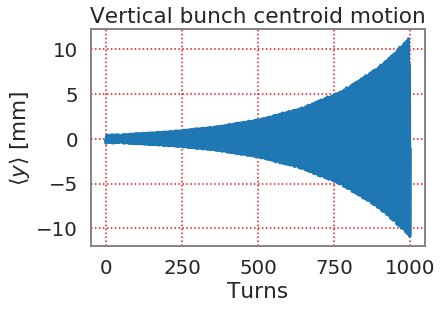

In [17]:
plt.plot(my * 1e3)
plt.xlabel('Turns')
plt.ylabel(r'$\langle y \rangle$ [mm]')
plt.title('Vertical bunch centroid motion');

$\leadsto$ centre-of-mass of the bunch grows exponentially $\implies$ head-tail instability!

The head-tail instability develops along the bunch:

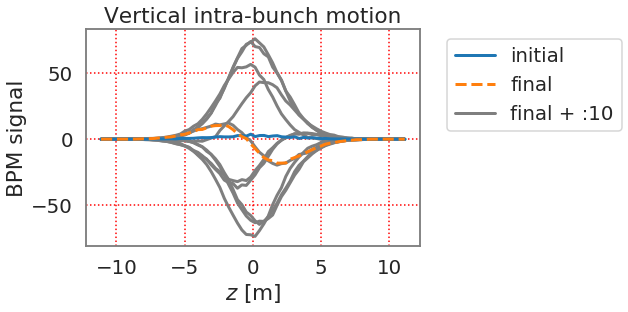

In [18]:
from imports import plot_intrabunch

plot_intrabunch(pyht_ring_elements, pyht_beam, slicer, slices0)

The SIS100 accelerator layout ("lattice") was simulated with a **simple matrix tracking** model in `PyHEADTAIL`. 

`SixTrackLib` can simulate the real lattice... shall we?

# ... example simulation with `SixTrackLib` ...

## ... tracking around the future FAIR SIS100 synchrotron ...

Importing SixTrackLib:

In [19]:
import sixtracklib as stl

In [20]:
# in absence of versioning, print current git commit for reference
import os
stl_dir = os.path.dirname(stl.__file__)
!printf "SixTrackLib " && cd $stl_dir && git log | head -1

SixTrackLib commit 947643d56dd16b0106f9efd71510053bceef8c2d


In [21]:
from cpymad.madx import Madx

In [22]:
madx = Madx()
madx.options.echo = False
madx.options.warn = False
madx.options.info = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2020.07.15 19:08:33      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [23]:
madx.call('./SIS100RING_220618_AllCold.seq')

In [24]:
madx.input('''
kqd := -0.2798446835; ! 18.84, 18.73 tune
kqf := 0.2809756135;

K1NL_S00QD1D :=  kqd ;
K1NL_S00QD1F :=  kqf ;
K1NL_S00QD2F :=  kqf ;
''')

True

In [25]:
from scipy.constants import c, e

In [26]:
Etot = np.sqrt((pyht_beam.p0)**2 + (pyht_beam.mass * c)**2) * c / e * 1e-9 # in GeV

In [27]:
madx.command.beam(particle='ion', mass=pyht_beam.mass * c**2 / e * 1e-9, charge=28, energy=Etot)

True

In [28]:
madx.input('''
!remove correctors
select, flag=seqedit, pattern=qs1j;
!remove all other elements
select, flag=seqedit, class=collimator;
select, flag=seqedit, class=kicker;
select, flag=seqedit, class=tkicker;
select, flag=seqedit, class=elseparator;
select, flag=seqedit, class=hmonitor;
select, flag=seqedit, class=multipole;
select, flag=seqedit, class=vmonitor;

seqedit, sequence=sis100cold;
    remove, element=selected;
    flatten;
endedit;

!remove remaining markers (besides $START which is required for MADX)
select, flag=seqedit, class=marker;
seqedit, sequence=SIS100cold;
    remove, element=selected;
    install, element=SIS100cold$START, s=0;
    flatten;
endedit;
''')

madx.use(sequence='sis100cold')

In [29]:
madx.twiss();

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0     0.004219524433        15.39459426 

                q1                dq1            betxmax              dxmax 
       18.83926403       -39.60084071        19.02839238        3.072291815 

             dxrms             xcomax             xcorms                 q2 
       1.438911722                  0                  0        18.74318541 

               dq2            betymax              dymax              dyrms 
      -39.60819988        19.12589274                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [30]:
madx.input('harmonic_number = 10;')

True

In [31]:
assert madx.command.select(
    flag='MAKETHIN',
    class_='QUADRUPOLE',
    slice_='9',
)

assert madx.command.select(
    flag='MAKETHIN',
    class_='SEXTUPOLE',
    slice_='1',
)

assert madx.command.select(
    flag='MAKETHIN',
    class_='SBEND',
    slice_='9',
)

assert madx.command.makethin(
    makedipedge=True,
    style='teapot',
    sequence='sis100cold',
)

makethin: style chosen : teapot
makethin: slicing sequence : sis100cold


In [32]:
madx.use(sequence='sis100cold')

In [33]:
madx.twiss();

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0     0.004219834408        15.39402883 

                q1                dq1            betxmax              dxmax 
       18.83850294       -39.79076481        19.59809408        3.135290881 

             dxrms             xcomax             xcorms                 q2 
       1.425941796                  0                  0        18.74332419 

               dq2            betymax              dymax              dyrms 
      -39.59751888        19.69098909                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [34]:
madx.input('''
    match, sequence=SIS100cold;
    global, sequence=SIS100cold, q1={qx}, q2={qy};
    vary, name=kqf, step=0.00001;
    vary, name=kqd, step=0.00001;
    lmdif, calls=500, tolerance=1.0e-10;
    endmatch;
'''.format(qx=18.84, qy=18.73)
)

START MATCHING

number of sequences: 1
sequence name: sis100cold
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   4.14736608e-11





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kqf                       2.80946e-01  2.80976e-01 -1.00000e+20  1.00000e+20
kqd                      -2.79727e-01 -2.79845e-01 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   4.14736608e-11


True

In [35]:
madx.twiss();

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0     0.004218745774        15.39601489 

                q1                dq1            betxmax              dxmax 
       18.84000043        -39.7815807        19.59448973         3.13327747 

             dxrms             xcomax             xcorms                 q2 
       1.425364133                  0                  0        18.72999952 

               dq2            betymax              dymax              dyrms 
      -39.57121814        19.69359337                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [56]:
madx.input('''
!!Chromaticity correction

k2nl_KSCH       :=      0                               ;
k2nl_KSCV       :=      0                               ;

K2NL_S16KS1CH   :=      k2nl_KSCH       ;
K2NL_S26KS1CH   :=      k2nl_KSCH       ;
K2NL_S36KS1CH   :=      k2nl_KSCH       ;
K2NL_S46KS1CH   :=      k2nl_KSCH       ;
K2NL_S56KS1CH   :=      k2nl_KSCH       ;
K2NL_S66KS1CH   :=      k2nl_KSCH       ;


K2NL_S18KS1CH   :=      k2nl_KSCH       ;
K2NL_S28KS1CH   :=      k2nl_KSCH       ;
K2NL_S38KS1CH   :=      k2nl_KSCH       ;
K2NL_S48KS1CH   :=      k2nl_KSCH       ;
K2NL_S58KS1CH   :=      k2nl_KSCH       ;
K2NL_S68KS1CH   :=      k2nl_KSCH       ;


K2NL_S1AKS1CH   :=      k2nl_KSCH       ;
K2NL_S2AKS1CH   :=      k2nl_KSCH       ;
K2NL_S3AKS1CH   :=      k2nl_KSCH       ;
K2NL_S4AKS1CH   :=      k2nl_KSCH       ;
K2NL_S5AKS1CH   :=      k2nl_KSCH       ;
K2NL_S6AKS1CH   :=      k2nl_KSCH       ;


K2NL_S1CKS1CH   :=      k2nl_KSCH       ;
K2NL_S2CKS1CH   :=      k2nl_KSCH       ;
K2NL_S3CKS1CH   :=      k2nl_KSCH       ;
K2NL_S4CKS1CH   :=      k2nl_KSCH       ;
K2NL_S5CKS1CH   :=      k2nl_KSCH       ;
K2NL_S6CKS1CH   :=      k2nl_KSCH       ;

K2NL_S15KS1CV   :=      k2nl_KSCV       ;
K2NL_S25KS1CV   :=      k2nl_KSCV       ;
K2NL_S35KS1CV   :=      k2nl_KSCV       ;
K2NL_S45KS1CV   :=      k2nl_KSCV       ;
K2NL_S55KS1CV   :=      k2nl_KSCV       ;
K2NL_S65KS1CV   :=      k2nl_KSCV       ;


K2NL_S17KS1CV   :=      k2nl_KSCV       ;
K2NL_S27KS1CV   :=      k2nl_KSCV       ;
K2NL_S37KS1CV   :=      k2nl_KSCV       ;
K2NL_S47KS1CV   :=      k2nl_KSCV       ;
K2NL_S57KS1CV   :=      k2nl_KSCV       ;
K2NL_S67KS1CV   :=      k2nl_KSCV       ;


K2NL_S1BKS1CV   :=      k2nl_KSCV       ;
K2NL_S2BKS1CV   :=      k2nl_KSCV       ;
K2NL_S3BKS1CV   :=      k2nl_KSCV       ;
K2NL_S4BKS1CV   :=      k2nl_KSCV       ;
K2NL_S5BKS1CV   :=      k2nl_KSCV       ;
K2NL_S6BKS1CV   :=      k2nl_KSCV       ;
''')

True

In [57]:
madx.input('''
    match, sequence=SIS100cold;
    global, sequence=SIS100cold, dq1={qpx}, dq2={qpy};
    vary, name=k2nl_KSCH, step=0.00001;
    vary, name=k2nl_KSCV, step=0.00001;
    lmdif, calls=500, tolerance=1.0e-10;
    endmatch;
'''.format(qpx=18.84 / pyht_beam.beta, qpy=18.73 / pyht_beam.beta)
)

START MATCHING

number of sequences: 1
sequence name: sis100cold
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   2.82664435e-20





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
k2nl_ksch                -1.54290e+00  0.00000e+00 -1.00000e+20  1.00000e+20
k2nl_kscv                 3.03133e+00  0.00000e+00 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   2.82664435e-20


True

In [58]:
madx.twiss();

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0     0.004577005258        14.78118642 

                q1                dq1            betxmax              dxmax 
       18.84000043        33.17042845        19.59448972        3.133575495 

             dxrms             xcomax             xcorms                 q2 
       1.425366455                  0                  0        18.72999952 

               dq2            betymax              dymax              dyrms 
       32.97675822        19.69359337                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [37]:
madx.input('''
cavity_voltage = {v} * 1e-6 / 14;
'''.format(v=longitudinal_map_kwargs['voltage_list'][0]))

True

In [38]:
madx.save(sequence='sis100cold', file='SIS100_thin_withsextupoles_pos-chroma.seq')

True

In [39]:
import pysixtrack

In [40]:
pysixtrack_elements = pysixtrack.Line.from_madx_sequence(
    madx.sequence.sis100cold, exact_drift=True, install_apertures=False
)
pysixtrack_elements.remove_zero_length_drifts(inplace=True);
pysixtrack_elements.merge_consecutive_drifts(inplace=True);

In [41]:
del elements, particles, trackjob

NameError: name 'elements' is not defined

In [42]:
elements = stl.Elements.from_line(pysixtrack_elements)
elements.BeamMonitor(num_stores=n_turns);

In [43]:
twiss = madx.twiss();

In [44]:
n_macroparticles = 1000

np.random.seed(0)

pyht_beam = generate_Gaussian6DTwiss(
    macroparticlenumber=n_macroparticles,
    intensity=intensity,
    alpha_x=twiss['alfx'][0],
    beta_x=twiss['betx'][0],
    dispersion_x=twiss['dx'][0] * pyht_beam.beta,
    alpha_y=twiss['alfy'][0],
    beta_y=twiss['bety'][0],
    dispersion_y=twiss['dy'][0] * pyht_beam.beta,
    **beam_kwargs,
)

In [45]:
particles = stl.Particles.from_ref(
    n_macroparticles, p0c=pyht_beam.p0 * c / e, 
    mass0=pyht_beam.mass*c**2/e, q0=28)

particles.x[:] = pyht_beam.x
particles.px[:] = pyht_beam.xp
particles.y[:] = pyht_beam.y
particles.py[:] = pyht_beam.yp
particles.zeta[:] = pyht_beam.z
particles.delta[:] = pyht_beam.dp

particles.rpp[:] = 1. / (pyht_beam.dp + 1)

p0 = pyht_beam.p0
beta = pyht_beam.beta
mass = pyht_beam.mass

restmass = mass * c**2
restmass_sq = restmass**2
E0 = np.sqrt((p0 * c)**2 + restmass_sq)
p = p0 * (1 + pyht_beam.dp)
E = np.sqrt((p * c)**2 + restmass_sq)
particles.psigma[:] = (E - E0) / (beta * p0 * c)

gammai = E / restmass
betai = np.sqrt(1 - 1. / (gammai * gammai))
particles.rvv[:] = betai / beta

In [ ]:
trackjob = stl.TrackJob(elements, particles, device='opencl:1.0')

In [46]:
# trackjob = stl.CudaTrackJob(elements, particles)

# trackjob.collect_beam_elements()
# trackjob.beam_elements_buffer.get_elements()[-1].max_particle_id = n_macroparticles - 1
# trackjob.push_beam_elements()

In [49]:
trackjob.track_until(n_turns)
trackjob.collect();

In [50]:
x = trackjob.output.particles[0].x
px = trackjob.output.particles[0].px
y = trackjob.output.particles[0].y
py = trackjob.output.particles[0].py
zeta = trackjob.output.particles[0].zeta
delta = trackjob.output.particles[0].delta

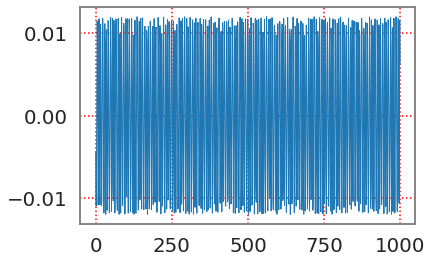

In [51]:
plt.plot(x[1::n_macroparticles], lw=1)

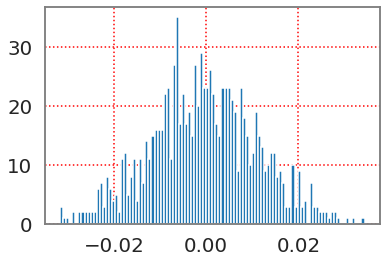

In [52]:
plt.hist(x[0:n_macroparticles], bins=100);

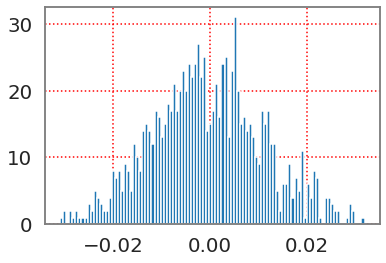

In [53]:
plt.hist(x[-n_macroparticles:], bins=100);

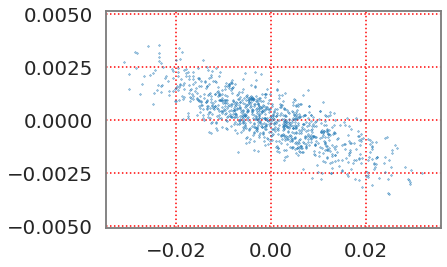

In [54]:
plt.scatter(x[-n_macroparticles:], 
            px[-n_macroparticles:],
            marker='.', s=1)

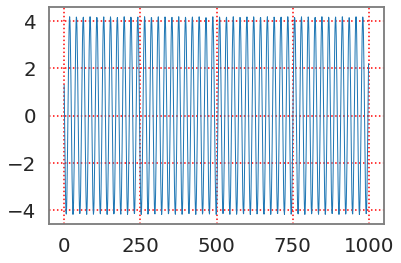

In [55]:
plt.plot(zeta[1::n_macroparticles], lw=1)

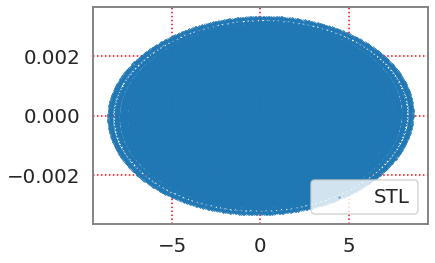

In [52]:
plt.scatter(zeta, 
            delta,
            marker='.', s=1, label='STL')
plt.legend()
plt.ylim(-max(abs(delta)) * 1.1, max(abs(delta)) * 1.1);

In [75]:
pbuffer = trackjob.particles_buffer.get_object(0)

In [76]:
np.sum(pbuffer.state)

1000

# ... well &ndash; let's try to unify, shan't we?

Integrate `SixTrackLib` tracking with wakefield kick from `PyHEADTAIL`